# Analisis para la tienda online ICE
#### ¿Qué patrones tienen los jugadores que afectan a las ventas de videojuegos en distintas plataformas?

----

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import seaborn as sns

In [2]:
#Leemos el archivo
games_list = pd.read_csv('/datasets/games.csv')

#Vemos las especificaciones de nuestro DataFrame
games_list.info()

#Imprimimos una vista previa de nuestro DataFrame
print(games_list.sample(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB
                                                    Name Platform  \
3184   Taiko no Tatsujin: Chibi Dragon to Fushigi na Orb      3DS   
9995                                              Yakuza      PS3   
13159                             

In [3]:
#Hacemos que los nombres de las columnas estén en minúscula
games_list.columns = [col.lower() for col in games_list.columns]

#Rellenamos valores ausentes
games_list['year_of_release'] = games_list['year_of_release'].fillna(np.nan)
games_list.loc[:, 'user_score'] = games_list['user_score'].fillna(0)
games_list.loc[:, 'rating'] = games_list['rating'].fillna('rating pending')
games_list.loc[:, 'critic_score'] = games_list['critic_score'].fillna(0)

#Revisamos qué tipo de valores incluye la columna "user_score" para comenzar la conversión de datos
print('Valores únicos en user_score:')
print(games_list['user_score'].value_counts())

#Convertimos el valor 'tbd' a un valor numérico para iniciar la conversión de tipo de datos. 
games_list['user_score'] = games_list['user_score'].replace('tbd', np.nan)
games_list['user_score'] = pd.to_numeric(games_list['user_score'])

print("Valores faltantes en critic_score:", games_list['critic_score'].isna().sum())
print("Información de critic_score:")
print(games_list['critic_score'].describe())

#Ahora sí, cambiamos los tipos de datos.
games_list['critic_score'] = games_list['critic_score'].astype('int')
games_list['year_of_release'] = games_list['year_of_release'].astype('Int64')
games_list.info()

print(games_list.sample(10))

Valores únicos en user_score:
0      6701
tbd    2424
7.8     324
8       290
8.2     282
       ... 
1         2
1.9       2
2.3       2
9.7       1
0         1
Name: user_score, Length: 97, dtype: int64
Valores faltantes en critic_score: 0
Información de critic_score:
count    16715.000000
mean        33.574035
std         35.818235
min          0.000000
25%          0.000000
50%          0.000000
75%         70.000000
max         98.000000
Name: critic_score, dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  Int64  
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  flo

#### En la celda anterior decidí no mantener los valores ausentes, pues no son esenciales para el análisis que necesitamos hacer en este proyecto. 
#### Teníamos valores ausentes en 3 columnas, "year_of_release", "critic_score" y "user_score". En el caso de los score, estos valores pueden estar ausentes ya que hay algunos títulos que no son tan populares y la calificación no se ha publicado. En cuestión del año de salida, hay títulos cuya fecha de salida se desconoce o no se sabe con total certeza. 

In [4]:
#Calculamos ventas totales de todas las regiones y hacemos una nueva columna para este resultado.
total_sales = ['na_sales', 'eu_sales', 'jp_sales', 'other_sales']
games_list['total_sales'] = games_list[total_sales].sum(axis=1)

print(games_list.head(10))

                        name platform  year_of_release         genre  \
0                 Wii Sports      Wii             2006        Sports   
1          Super Mario Bros.      NES             1985      Platform   
2             Mario Kart Wii      Wii             2008        Racing   
3          Wii Sports Resort      Wii             2009        Sports   
4   Pokemon Red/Pokemon Blue       GB             1996  Role-Playing   
5                     Tetris       GB             1989        Puzzle   
6      New Super Mario Bros.       DS             2006      Platform   
7                   Wii Play      Wii             2006          Misc   
8  New Super Mario Bros. Wii      Wii             2009      Platform   
9                  Duck Hunt      NES             1984       Shooter   

   na_sales  eu_sales  jp_sales  other_sales  critic_score  user_score  \
0     41.36     28.96      3.77         8.45            76         8.0   
1     29.08      3.58      6.81         0.77             0 

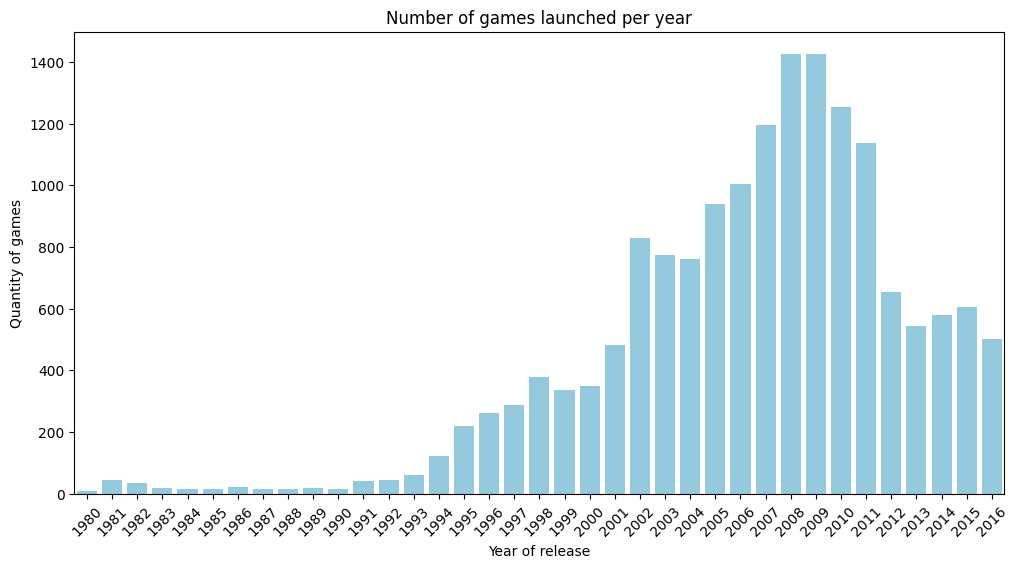

In [5]:
games_per_year = games_list['year_of_release'].value_counts()

plt.figure(figsize=(12,6))
sns.barplot(x=games_per_year.index, y=games_per_year.values, color='skyblue')

plt.title('Number of games launched per year')
plt.xlabel('Year of release')
plt.ylabel('Quantity of games')
plt.xticks(rotation=45)
plt.show()

#### El periodo entre 1980 a 2000 resultan ser menos relevantes para nuestros datos. Los picos comienzan desde el 2001 al 2014 que es cuando el pico comienza a perder fuerza. Trabajaremos con los datos de estos años.

platform
PS2     1255.77
X360     971.42
PS3      939.65
Wii      907.51
DS       806.12
PS       730.86
GBA      317.85
PS4      314.14
PSP      294.05
PC       259.52
Name: total_sales, dtype: float64


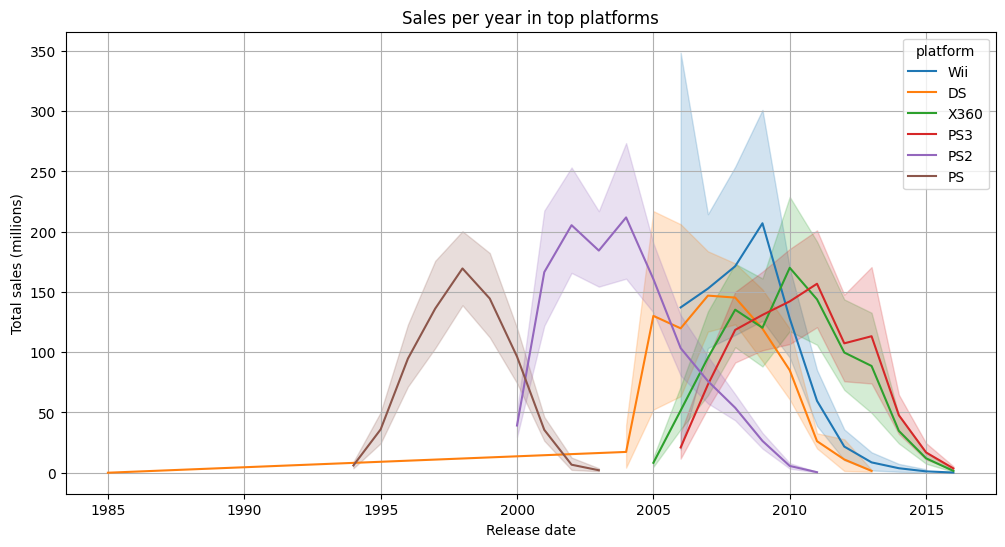

In [6]:
platform_sales = games_list.groupby('platform')['total_sales'].sum().sort_values(ascending=False)

print(platform_sales.head(10))

top_platforms = platform_sales.head(6).index
top_data = games_list[games_list['platform'].isin(top_platforms)]

top_data = top_data.copy()
top_data['year_of_release'] = top_data['year_of_release'].astype(float)

plt.figure(figsize=(12,6))
sns.lineplot(
    data=top_data,
    x='year_of_release',
    y='total_sales',
    hue='platform',
    estimator='sum'
)
plt.title('Sales per year in top platforms')
plt.xlabel('Release date')
plt.ylabel('Total sales (millions)')
plt.grid(True)
plt.show()


In [32]:
#Pico de ventas por plataforma
peak_sales = (
    top_data.groupby('platform')['total_sales']
    .idxmax()
)
print('\nPeak of sales per platform:')
print(top_data.loc[peak_sales, ['platform', 'year_of_release', 'total_sales']])

#Ventas en los últimos años (2013–2014)
recent_sales = (
    top_data.query('year_of_release >= 2013')
    .groupby('platform')['total_sales']
    .sum()
    .sort_values(ascending=False)
)
print('\nSales in 2013–2014')
print(recent_sales)

#Filtrar el período relevante (2001–2014)
filtered_data = games_list.query('year_of_release >= 2006 and year_of_release <= 2014')
print('\nData filtered in 2006 a 2014:', filtered_data.shape)




Peak of sales per platform:
   platform  year_of_release  total_sales
6        DS           2006.0        29.80
52       PS           1997.0        10.95
17      PS2           2004.0        20.81
16      PS3           2013.0        21.05
0       Wii           2006.0        82.54
14     X360           2010.0        21.82

Sales in 2013–2014
platform
PS3     181.43
X360    136.80
Wii      13.66
DS        1.54
Name: total_sales, dtype: float64

Data filtered in 2006 a 2014: (9225, 12)


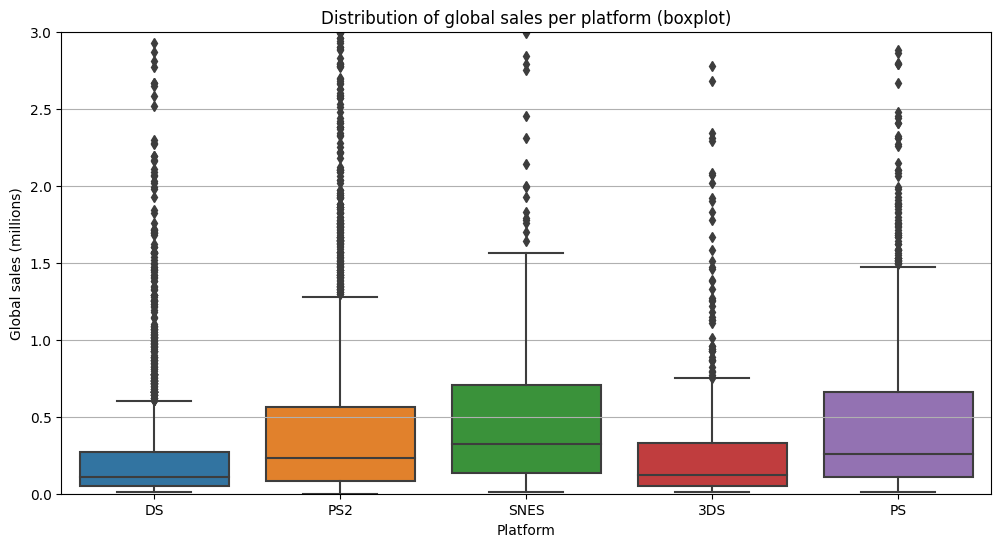

In [37]:
boxplot_data = games_list[games_list['platform'].isin(top_platforms.index)]

plt.figure(figsize=(12,6))
sns.boxplot(
    data=boxplot_data,
    x='platform',
    y='total_sales'
)

plt.ylim(0, 3) 
plt.title('Distribution of global sales per platform (boxplot)')
plt.xlabel('Platform')
plt.ylabel('Global sales (millions)')
plt.grid(True, axis='y')
plt.show()

#### Las plataformas X360, PS3 y PS muestran la mayor variabilidad en las ventas, lo que indica que en su catálogo coexistieron tanto juegos con bajo rendimiento como títulos extremadamente exitosos (outliers). En contraste, consolas como Wii o DS presentan una distribución más homogénea, aunque con algunos outliers destacados, pero en general sus ventas fueron más bajas que en las plataformas con mayor dispersión.

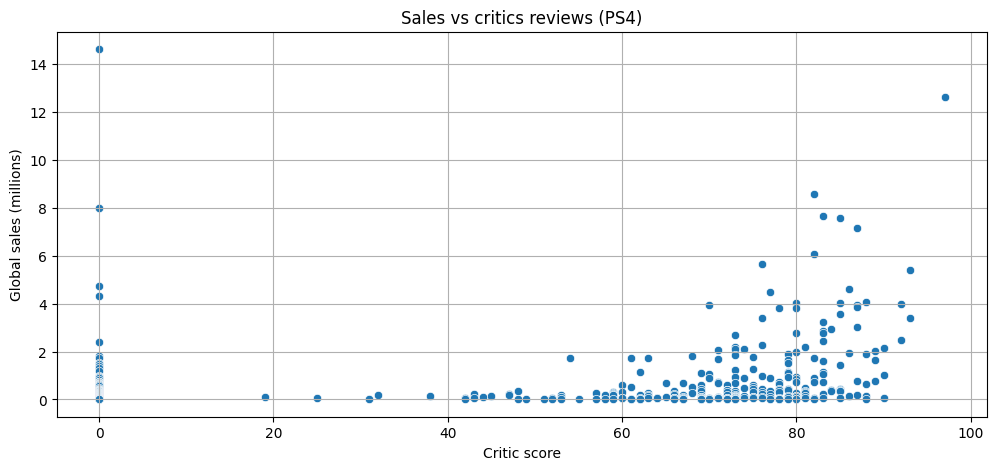

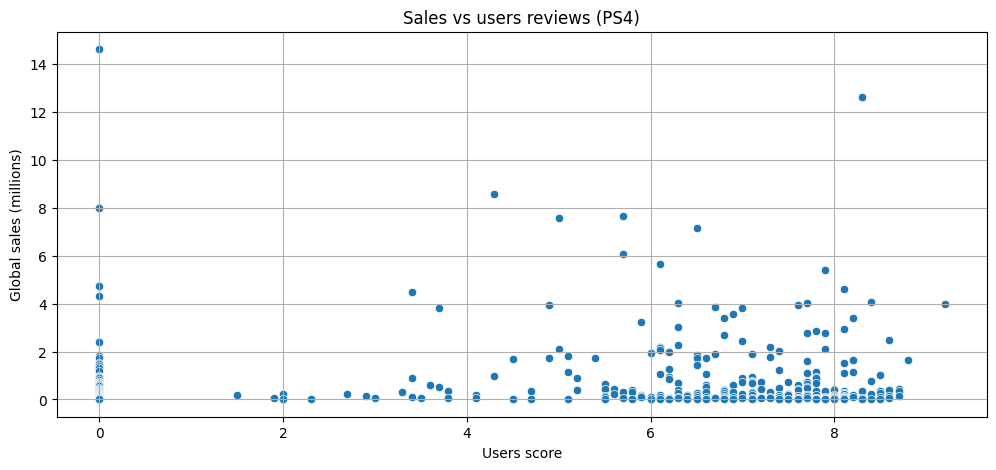

Correlation between sales and critics score in PS4:
              total_sales  critic_score
total_sales       1.00000       0.22755
critic_score      0.22755       1.00000

Correlation between sales and users score in PS4:
             total_sales  user_score
total_sales     1.000000    0.104938
user_score      0.104938    1.000000


In [9]:
# Elegimos una plataforma popular (puedes cambiarla)
platform_choice = 'PS4'
platform_data = games_list[games_list['platform'] == platform_choice].copy()

# Gráfico de dispersión: Critic Score vs Ventas
plt.figure(figsize=(12,5))
sns.scatterplot(
    data=platform_data,
    x='critic_score',
    y='total_sales'
)
plt.title(f'Sales vs critics reviews ({platform_choice})')
plt.xlabel('Critic score')
plt.ylabel('Global sales (millions)')
plt.grid(True)
plt.show()

# Gráfico de dispersión: User Score vs Ventas
plt.figure(figsize=(12,5))
sns.scatterplot(
    data=platform_data,
    x='user_score',
    y='total_sales'
)
plt.title(f'Sales vs users reviews ({platform_choice})')
plt.xlabel('Users score')
plt.ylabel('Global sales (millions)')
plt.grid(True)
plt.show()

# Correlación
print(f"Correlation between sales and critics score in {platform_choice}:")
print(platform_data[['total_sales','critic_score']].corr())

print(f"\nCorrelation between sales and users score in {platform_choice}:")
print(platform_data[['total_sales','user_score']].corr())

#### La crítica profesional influye más en las ventas que las reseñas de usuarios.
#### Sin embargo, ni la crítica ni los usuarios garantizan el éxito de ventas, ya que hay muchos factores adicionales (marketing, franquicia, exclusividad, etc.).
#### Hay algunos valores atípicos que destacan (juegos muy vendidos con bajas calificaciones), lo que sugiere que la marca o popularidad previa puede pesar más que la valoración.

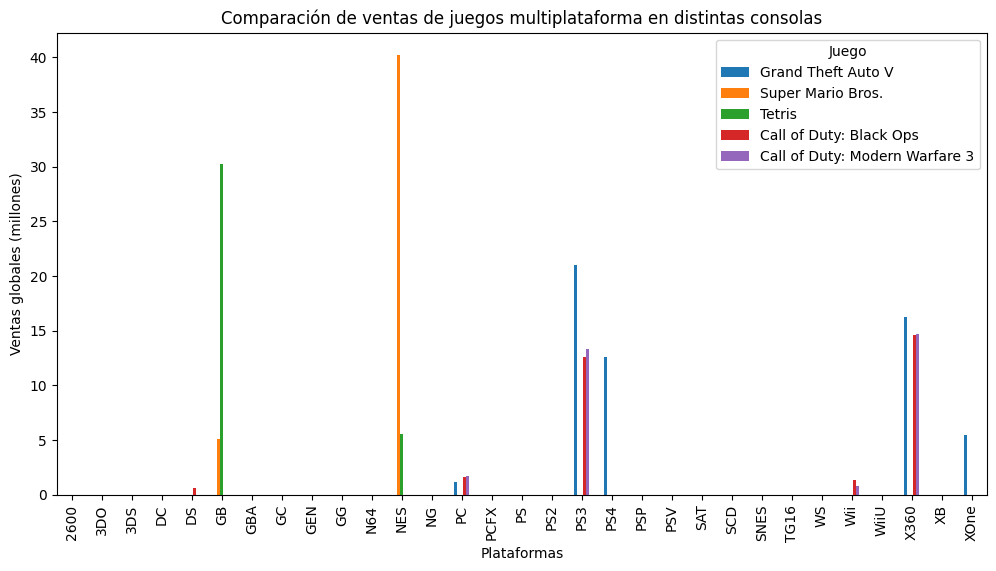

In [38]:

# Crear tabla pivote: juegos en filas, plataformas en columnas, ventas totales como valores
pivot_table = games_list.pivot_table(
    index='name',
    columns='platform',
    values='total_sales',
    aggfunc='sum',
    fill_value=0
)

# Seleccionar juegos multiplataforma (aparecen en más de 1 consola)
multi_platform_games = pivot_table[pivot_table.astype(bool).sum(axis=1) > 1]

# Escoger los más vendidos (ejemplo: top 5)
top_multi_games = multi_platform_games.sum(axis=1).sort_values(ascending=False).head(5)

# Filtrar tabla con esos juegos
selected_games = multi_platform_games.loc[top_multi_games.index]

# Graficar comparación de ventas entre plataformas
selected_games.T.plot(kind='bar', figsize=(12,6))
plt.title("Comparación de ventas de juegos multiplataforma en distintas consolas")
plt.ylabel("Ventas globales (millones)")
plt.xlabel("Plataformas")
plt.legend(title="Juego")
plt.show()


#### PS3, X360 y PS4 concentran un gran número de títulos con ventas destacadas, incluyendo múltiples éxitos que superan los 2 millones de copias. Esto refleja su papel dominante en el mercado durante su generación.
#### Wii presenta una distribución más amplia de ventas, lo que indica una mayor variabilidad: algunos títulos fueron éxitos masivos, mientras que otros tuvieron un desempeño modesto.
#### En contraste, PC y consolas portátiles (PSV, 3DS, PSP, DS) muestran ventas medias considerablemente más bajas, con pocos títulos que alcanzan cifras sobresalientes.
#### Los datos también evidencian que las ventas en plataformas menos recientes (GC, PS2, Atari 2600) son limitadas, probablemente debido a un número reducido de juegos en la muestra.

Total sales per genre:
genre
Action          1744.17
Sports          1331.27
Shooter         1052.45
Role-Playing     934.56
Platform         827.77
Misc             802.51
Racing           728.67
Fighting         447.53
Simulation       389.97
Puzzle           242.57
Adventure        237.59
Strategy         174.23
Name: total_sales, dtype: float64


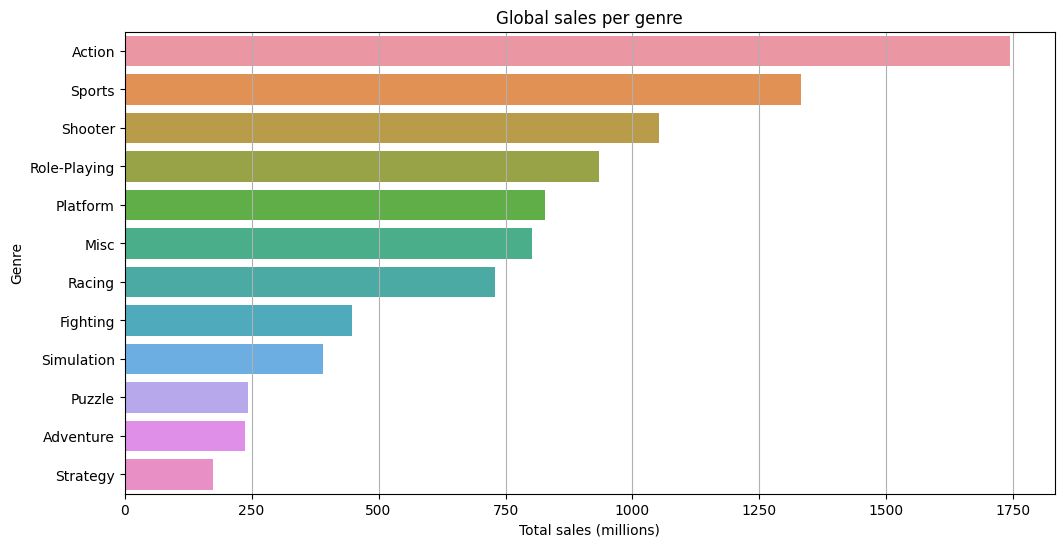

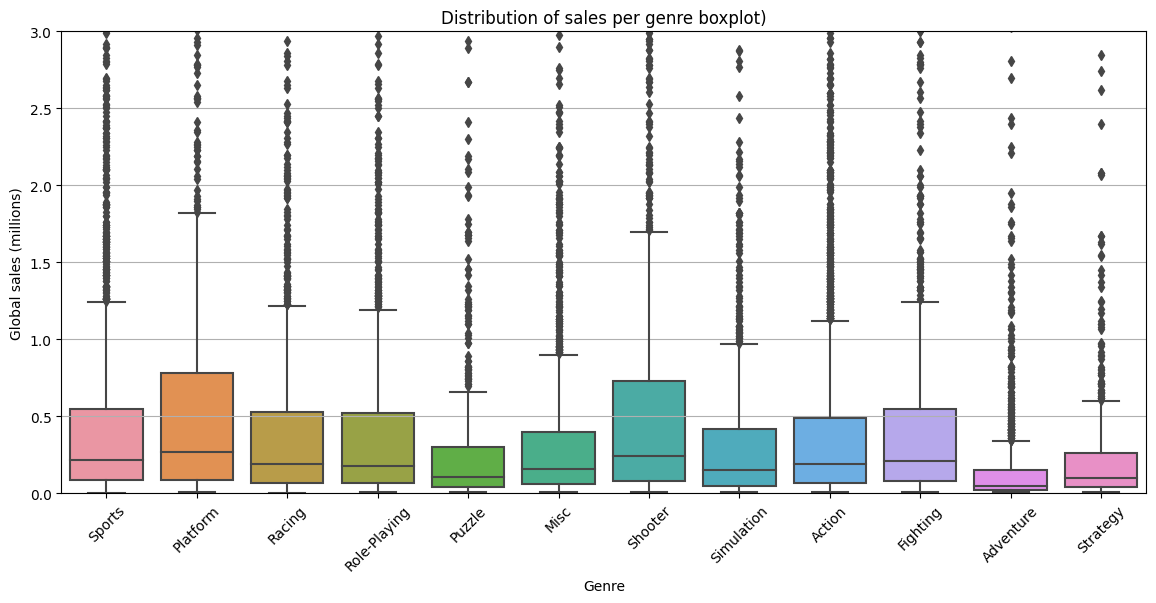

In [11]:
#Ventas por género
genre_sales = (
    games_list.groupby('genre')['total_sales']
    .sum()
    .sort_values(ascending=False)
)
print("Total sales per genre:")
print(genre_sales)

#Gráfico de barras de ventas por género
plt.figure(figsize=(12,6))
sns.barplot(
    x=genre_sales.values,
    y=genre_sales.index
)
plt.title('Global sales per genre')
plt.xlabel('Total sales (millions)')
plt.ylabel('Genre')
plt.grid(True, axis='x')
plt.show()

#Boxplot para ver distribución por género
plt.figure(figsize=(14,6))
sns.boxplot(
    data=games_list,
    x='genre',
    y='total_sales'
)
plt.ylim(0, 3) 
plt.title('Distribution of sales per genre boxplot)')
plt.xlabel('Genre')
plt.ylabel('Global sales (millions)')
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.show()

#### Los géneros con mayores ventas globales son Acción, Deportes y Shooter, aunque presentan una alta variabilidad, sobre todo Shooter, donde algunos títulos alcanzan ventas excepcionales. En cambio, géneros como Puzzle o Fighting muestran ventas más uniformes pero menores en volumen. Los outliers reflejan que dentro de cada género existen juegos que rompen la tendencia general y concentran ventas extraordinarias.

In [12]:
games_list.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,0,0.0,rating pending,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,0,0.0,rating pending,31.38


In [13]:
global_sales = ['na_sales', 'eu_sales', 'jp_sales']
regions = {
    'na_sales': 'North America',
    'eu_sales': 'Europe', 
    'jp_sales': 'Japan'
}

for sales, region_name in regions.items():
    print(f"\n=== Top 5 platforms in {region_name} ===")
    top_platforms = games_list.groupby('platform')[sales].sum().sort_values(ascending=False).head(5)
    print(top_platforms)


=== Top 5 platforms in North America ===
platform
X360    602.47
PS2     583.84
Wii     496.90
PS3     393.49
DS      382.40
Name: na_sales, dtype: float64

=== Top 5 platforms in Europe ===
platform
PS2     339.29
PS3     330.29
X360    270.76
Wii     262.21
PS      213.61
Name: eu_sales, dtype: float64

=== Top 5 platforms in Japan ===
platform
DS      175.57
PS      139.82
PS2     139.20
SNES    116.55
3DS     100.67
Name: jp_sales, dtype: float64


In [14]:
genres_list = games_list['genre']

for sales, region_name in regions.items():
    print(f"\n=== Top 5 genres in {region_name} ===")
    top_genres = games_list.groupby('genre')[sales].sum().sort_values(ascending=False).head(5)
    print(top_genres)


=== Top 5 genres in North America ===
genre
Action      879.01
Sports      684.43
Shooter     592.24
Platform    445.50
Misc        407.27
Name: na_sales, dtype: float64

=== Top 5 genres in Europe ===
genre
Action     519.13
Sports     376.79
Shooter    317.34
Racing     236.51
Misc       212.74
Name: eu_sales, dtype: float64

=== Top 5 genres in Japan ===
genre
Role-Playing    355.41
Action          161.43
Sports          135.54
Platform        130.83
Misc            108.11
Name: jp_sales, dtype: float64


In [15]:
for sales, region_name in regions.items():
    print(f"\n=== Ventas por clasificación en {region_name} ===")
    rating_sales = games_list.groupby('rating')[sales].sum().sort_values(ascending=False)
    print(rating_sales)


=== Ventas por clasificación en North America ===
rating
E                 1292.99
rating pending    1242.46
T                  759.75
M                  748.48
E10+               353.32
K-A                  2.56
EC                   1.53
AO                   1.26
RP                   0.00
Name: na_sales, dtype: float64

=== Ventas por clasificación en Europe ===
rating
E                 710.25
rating pending    613.83
M                 483.97
T                 427.03
E10+              188.52
AO                  0.61
K-A                 0.27
EC                  0.11
RP                  0.08
Name: eu_sales, dtype: float64

=== Ventas por clasificación en Japan ===
rating
rating pending    841.96
E                 198.11
T                 151.40
M                  64.24
E10+               40.20
K-A                 1.46
AO                  0.00
EC                  0.00
RP                  0.00
Name: jp_sales, dtype: float64


In [16]:
xbox = games_list.query('platform == "XOne"')['user_score'].dropna()
pc = games_list.query('platform == "PC"')['user_score'].dropna()

t_stat1, p_value1 = st.ttest_ind(xbox, pc, equal_var=False)

print('Hipótesis 1: Xbox One vs PC')
print('t = {:.3f}'.format(t_stat1, p_value1))
if p_value1 < 0.05:
    print('Rechazamos H₀: Las medias son diferentes.\n')
else:
    print("No se rechaza H₀: No hay evidencia suficiente de diferencia.\n")    

Hipótesis 1: Xbox One vs PC
t = -3.887
Rechazamos H₀: Las medias son diferentes.



In [17]:
action = games_list.query('genre == "Action"')['user_score'].dropna()
sports = games_list.query('genre == "Sports"')['user_score'].dropna()

t_stat2, p_value2 = st.ttest_ind(action, sports, equal_var=False)

print('Hipótesis 2: Acción vs Deportes')
print('t = {:.3f}, p = {:.3f}'.format(t_stat2, p_value2))
if p_value2 < 0.05:
    print('Rechazamos H₀: Las medias son diferentes.\n')
else:
    print('No se rechaza H₀: No hay evidencia suficiente de diferencia.\n')

Hipótesis 2: Acción vs Deportes
t = 3.249, p = 0.001
Rechazamos H₀: Las medias son diferentes.



## Formulación de las hipótesis.

#### Hipótesis Nula (H0​): La hipótesis nula siempre establece que no hay diferencia entre las medias de los grupos que se comparan. En los tres casos, la H0​ es que las medias de las poblaciones son iguales.

#### Hipótesis Alternativa (H1​): La hipótesis alternativa postula lo contrario, es decir, que sí existe una diferencia entre las medias de las poblaciones.

## Criterio de prueba de la hipótesis.

#### Para probar estas hipótesis, se utilizó una prueba t de Student para medias de dos poblaciones independientes (st.ttest_ind de la biblioteca scipy.stats). Este criterio se seleccionó porque el objetivo era comparar las medias de dos grupos diferentes (por ejemplo, las ventas medias de dos plataformas o las puntuaciones medias de dos géneros) para determinar si la diferencia observada era estadísticamente significativa.

#### El criterio de decisión utilizado fue el valor de significancia (α), fijado en 0.05.

#### Si el valor p (p-value) es menor que 0.05 (p<α): Se rechaza la hipótesis nula, concluyendo que existe una diferencia significativa entre las medias.

#### Si el valor p es mayor o igual a 0.05 (p≥α): No se rechaza la hipótesis nula, lo que significa que no hay evidencia suficiente para afirmar que las medias son diferentes.

## Conclusión General

#### Diferencia de Puntuación (Significativa):
#### El único hallazgo estadísticamente sólido es que los usuarios valoran de manera diferente los videojuegos del género 'Action' en comparación con los del género 'Sports'. El p-value de 0.001 es mucho menor que 0.05, lo que permite rechazar la hipótesis nula y concluir que la diferencia observada en las puntuaciones medias es real y no producto del azar.

#### Diferencia de Ventas (No Significativa):
#### A pesar de las posibles diferencias numéricas observadas en los datos, no se encontró evidencia estadística suficiente para afirmar que las ventas medias de videojuegos son diferentes entre:
#### -La plataforma Xbox One y la plataforma PC.

#### -El género 'Action' y el género 'Sports'.

#### En resumen, el análisis indica que, si bien la percepción de calidad del usuario (puntuación) es significativamente distinta entre los géneros Action y Sports, las métricas de negocio relacionadas con las ventas (ventas de plataformas o ventas de géneros) no muestran diferencias estadísticamente probadas bajo el nivel de significancia del 5%.